In [3]:
import pandas as pd
import database_load
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def dataframe_creation(cursor, query):
    #load query results into pd df
    cursor.execute(query)
    colnames = [col[0] for col in cursor.description]
    df = pd.DataFrame(cursor.fetchall(), columns=colnames)
    return df


db_connection = database_load.connect_database()
db_cursor = db_connection.cursor()

df = dataframe_creation(db_cursor, 'select * from games')

#close database connection
db_cursor.close()
db_connection.close()

In [5]:
def split_creation(df_in, col_in, step):
    max_rating= df_in[col_in].max()
    min_ratings= df_in[col_in].min()-df_in[col_in].min()%step
    split = []
    while min_ratings <= max_rating:
        split.append(min_ratings)
        min_ratings+= step
    return split
    
#take rating_avg, split into different df
def tier_creation(df_in, col_in, col_out, step):
    tiers = split_creation(df_in, col_in, step)
    tiers.append(float('inf'))
    df_in[col_out] = pd.cut(df_in[col_in], bins=tiers, labels=tiers[:-1], right=False)

In [6]:
results_df = pd.DataFrame(columns=['rating_diff', 'rating_avg', 'winner'])
results_df['rating_diff'] = df['white_rating']-df['black_rating']
results_df['rating_avg'] = (df['white_rating']+df['black_rating'])/2

#If white is favoured, return 1 if white wins, or -1 if loss
#If black is favoured, return 1 if black wins
#retuns 0 if draw
winner_conditions = [(results_df['rating_diff']>0) & (df['winner'] == 'white'),
                     (results_df['rating_diff']<0) & (df['winner'] == 'white'),
                     (results_df['rating_diff']<0) & (df['winner'] == 'black'),
                     (results_df['rating_diff']>0) & (df['winner'] == 'black')]

winner_results = [1,-1,1,-1]

results_df['winner'] = np.select(winner_conditions,winner_results, default=0)


In [ ]:
#create list of dataframes for each rank
tier_creation(results_df, 'rating_avg', 'rank', 200)
rank_list = split_creation(results_df, 'rank', 200)
results_df['rank'] = results_df['rank'].astype(int)

results_df_ls = []
for rank in rank_list:
    filt = (results_df['rank'] >= rank) & (results_df['rank'] < (rank+200))
    selected_rank_df = results_df[filt].reset_index(drop=True)
    #Check if there is an appropriate amount of samples
    if selected_rank_df.shape[0] > 100:
        results_df_ls.append(selected_rank_df)

In [35]:
graph_df_ls = []
for rank in results_df_ls:
    #This tallies up the scores to see if favoured wins are more prevalant
    #and keeps track of how many games there were
    tier_creation(rank, 'rating_diff', 'diff_rank',200)
    graph_df = rank.groupby('diff_rank', observed=False).agg(rank=('rank', 'first'), win_amount=('winner', 'sum'), game_amount=('winner','count')).reset_index()
    graph_df_ls.append(graph_df)

print(graph_df_ls[6])

  diff_rank  rank  win_amount  game_amount
0     -1000  2200           1            1
1      -800  2200          -1            1
2      -600  2200           7            7
3      -400  2200          12           22
4      -200  2200          15           94
5         0  2200          23           85
6       200  2200          16           22
7       400  2200           0            8
8       600  2200           0            2
9       800  2200           2            2


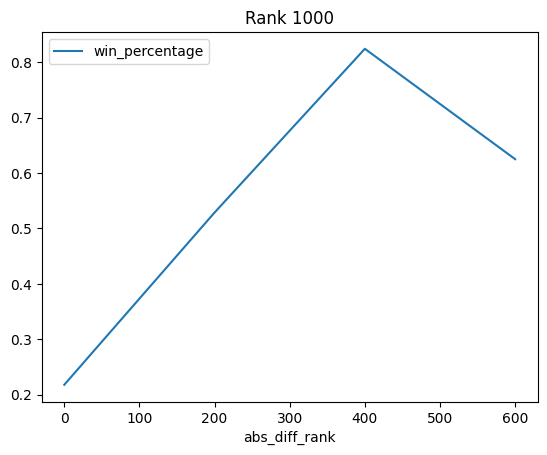

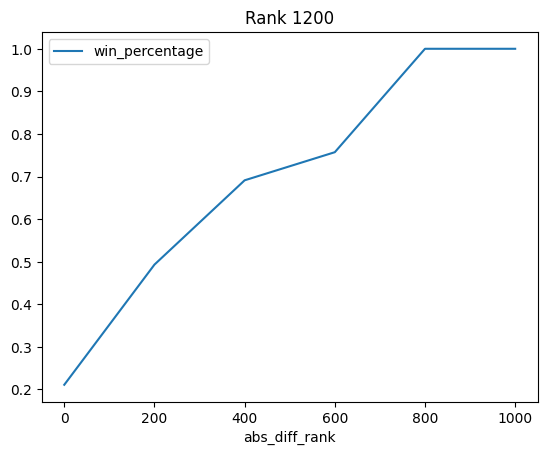

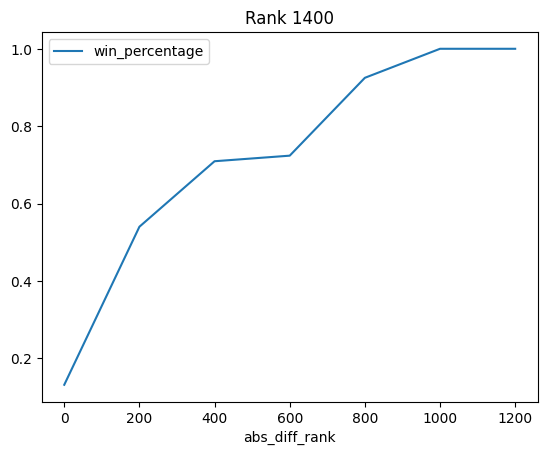

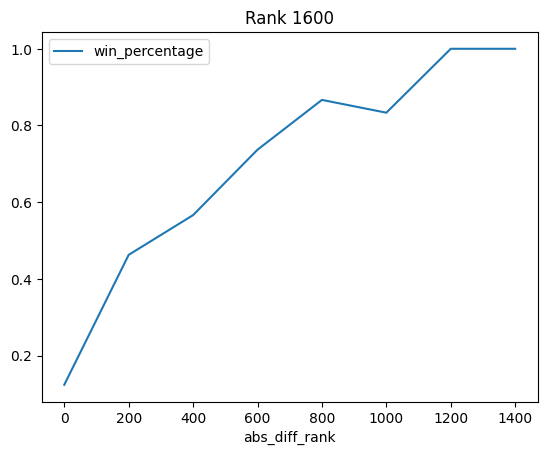

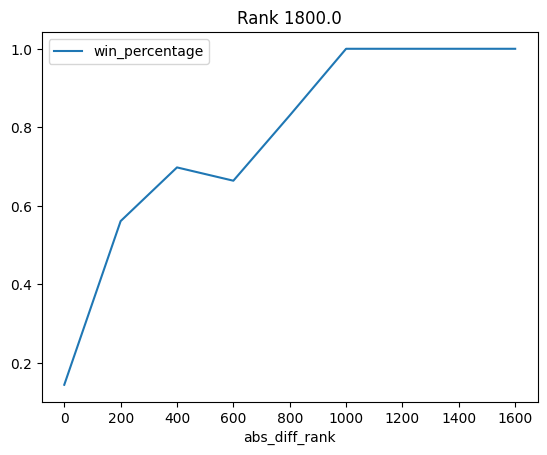

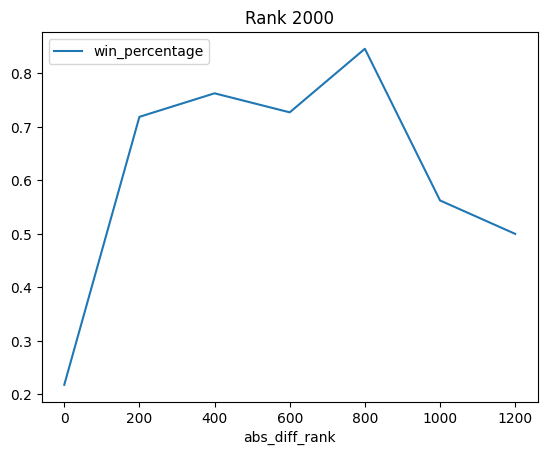

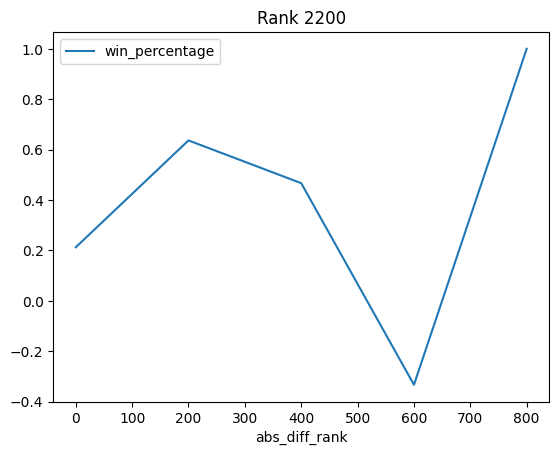

In [37]:
#tallies up black and white favoured games
abs_graph_df_ls = []
for graph_df in graph_df_ls:
    graph_df['abs_diff_rank'] = graph_df['diff_rank'].apply(lambda x: abs(x+200) if x<0 else x)

    abs_graph_df = graph_df.groupby('abs_diff_rank', observed=False).agg(rank=('rank', 'first'), win_amount=('win_amount', 'sum'), game_amount=('game_amount', 'sum')).reset_index()
    abs_graph_df['win_percentage']=abs_graph_df['win_amount']/abs_graph_df['game_amount']

    graph = abs_graph_df.plot(x='abs_diff_rank', y='win_percentage')
    graph.set_title('Rank ' + graph_df['rank'][0].astype(str))
    abs_graph_df_ls.append(abs_graph_df)

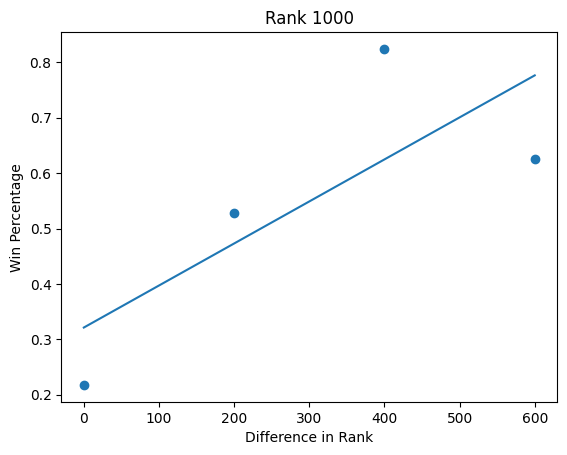

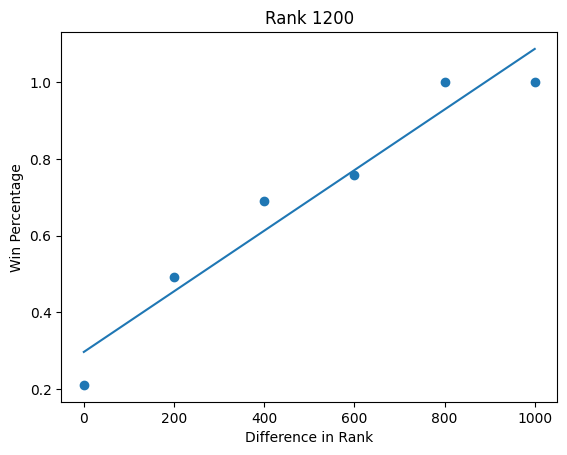

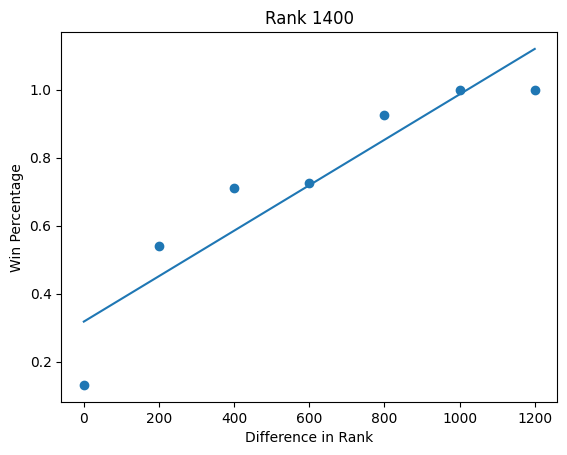

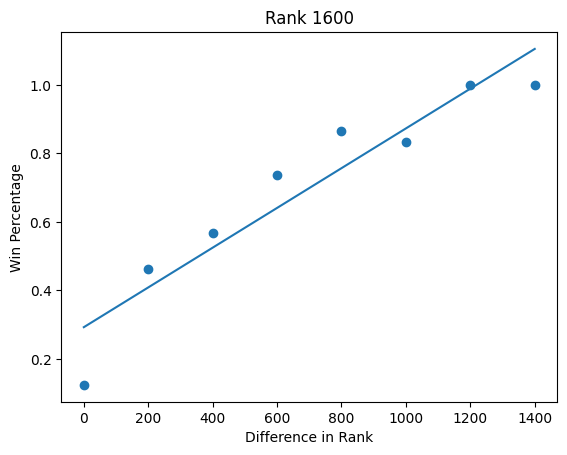

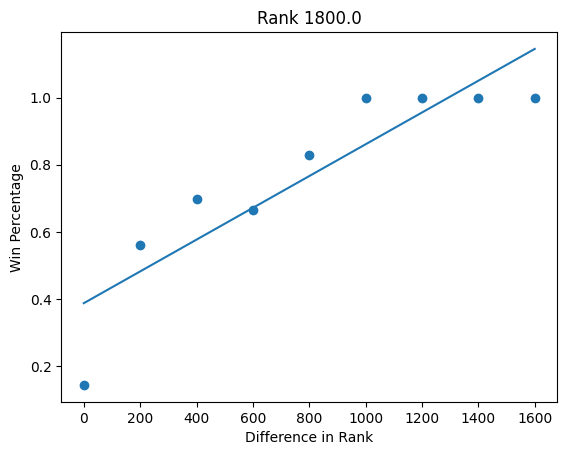

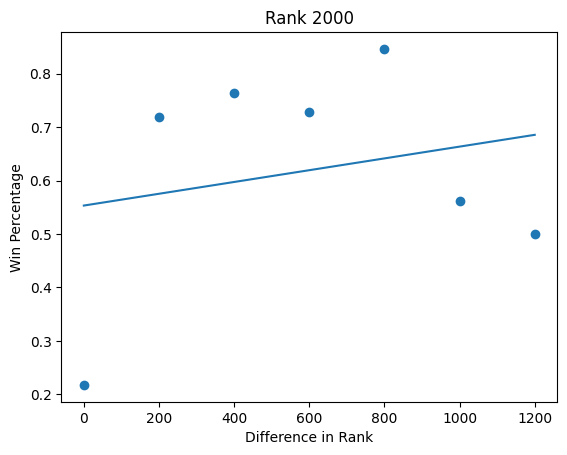

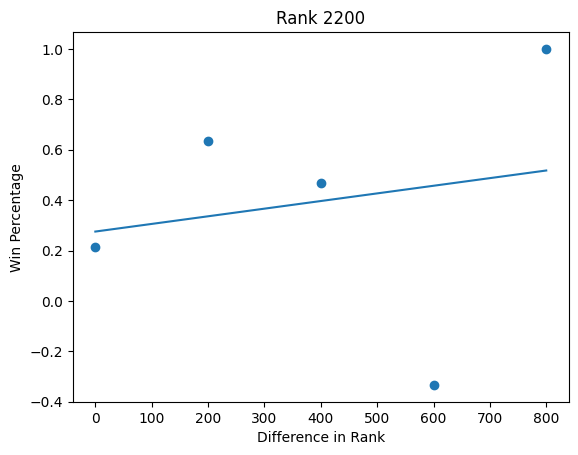

In [38]:
#try linear line of best fit
for abs_graph_df in abs_graph_df_ls:
    plt.figure()
    plt.scatter(abs_graph_df['abs_diff_rank'], abs_graph_df['win_percentage'])
    a, b = np.polyfit(abs_graph_df['abs_diff_rank'], abs_graph_df['win_percentage'], 1)
    plt.plot(abs_graph_df['abs_diff_rank'], a*abs_graph_df['abs_diff_rank']+b)
    plt.xlabel("Difference in Rank")
    plt.ylabel("Win Percentage")
    plt.title("Rank "+ abs_graph_df['rank'][0].astype(str))

We can draw a conclusion from the line of best fit that generally the win percentage is correlated to the difference in rank. The larger the rank difference, the more likely a player is to win. This impact of this is lessened as ranks get higher, perhaps because both players generally know what they are doing. It could also be an effect of less data points to rely on, as higher rank games are usually less common.